In [29]:
!curl https://course.fast.ai/setup/colab | bash

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   322  100   322    0     0   1114      0 --:--:-- --:--:-- --:--:--  1110
Updating fastai...
Done.


In [30]:

from fastai.vision import *
from fastai.callbacks import *
from google.colab import drive
drive.mount('/content/drive',force_remount=False)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import os
abs_path="/content/drive/My Drive/Colab Notebooks/fastai"

In [32]:
from fastai.utils.collect_env import *
show_install(True)



```text
=== Software === 
python        : 3.6.9
fastai        : 1.0.60
fastprogress  : 0.2.2
torch         : 1.4.0
nvidia driver : 418.67
torch cuda    : 10.1 / is available
torch cudnn   : 7603 / is enabled

=== Hardware === 
nvidia gpus   : 1
torch devices : 1
  - gpu0      : 16280MB | Tesla P100-PCIE-16GB

=== Environment === 
platform      : Linux-4.14.137+-x86_64-with-Ubuntu-18.04-bionic
distro        : #1 SMP Thu Aug 8 02:47:02 PDT 2019
conda env     : Unknown
python        : /usr/bin/python3
sys.path      : 
/env/python
/usr/lib/python36.zip
/usr/lib/python3.6
/usr/lib/python3.6/lib-dynload
/usr/local/lib/python3.6/dist-packages
/usr/lib/python3/dist-packages
/usr/local/lib/python3.6/dist-packages/IPython/extensions
/root/.ipython

Fri Apr  3 05:36:10 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.64.00    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+-

In [33]:
path = Path(abs_path+'/data')
path.ls()

[PosixPath('/content/drive/My Drive/Colab Notebooks/fastai/data/masks-256'),
 PosixPath('/content/drive/My Drive/Colab Notebooks/fastai/data/images-256')]

In [0]:
path_lbl = path/'masks-256'
path_img = path/'images-256'

In [35]:
fnames = get_image_files(path_img)
lbl_names = get_image_files(path_lbl)
print(len(fnames), len(lbl_names))
fnames[:3], lbl_names[:3] 

637 637


([PosixPath('/content/drive/My Drive/Colab Notebooks/fastai/data/images-256/znz001trn_19_153778_197268.png'),
  PosixPath('/content/drive/My Drive/Colab Notebooks/fastai/data/images-256/znz001trn_19_153779_197288.png'),
  PosixPath('/content/drive/My Drive/Colab Notebooks/fastai/data/images-256/znz001trn_19_153772_197284.png')],
 [PosixPath('/content/drive/My Drive/Colab Notebooks/fastai/data/masks-256/znz001trn_19_153773_197295_mask.png'),
  PosixPath('/content/drive/My Drive/Colab Notebooks/fastai/data/masks-256/znz001trn_19_153776_197293_mask.png'),
  PosixPath('/content/drive/My Drive/Colab Notebooks/fastai/data/masks-256/znz001trn_19_153775_197288_mask.png')])

In [0]:
get_y_fn = lambda x: path_lbl/f'{x.stem}_mask.png'

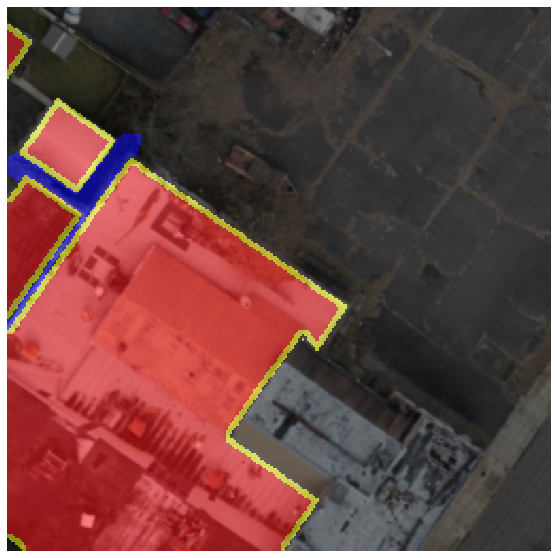

In [37]:
img_f = fnames[25]
img = open_image(img_f)
mask = open_mask(get_y_fn(img_f), convert_mode='RGB', div=False)

fig,ax = plt.subplots(1,1, figsize=(10,10))
img.show(ax=ax)
mask.show(ax=ax, alpha=0.5)

(array([171035.,      0.,  25573.]),
 array([  0.,  85., 170., 255.]),
 <a list of 3 Patch objects>)

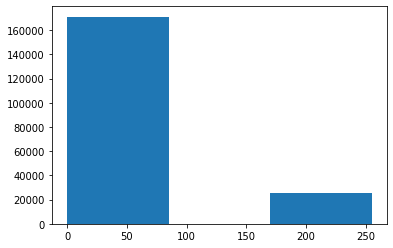

In [38]:
plt.hist(mask.data.view(-1), bins=3)

In [39]:
holdout_grids = ['znz001val_']
valid_idx = [i for i,o in enumerate(fnames) if any(c in str(o) for c in holdout_grids)]
print(len(valid_idx))

239


In [0]:
class SegLabelListCustom(SegmentationLabelList):
    def open(self, fn): return open_mask(fn, div=True, convert_mode='RGB')
    
class SegItemListCustom(SegmentationItemList):
    _label_cls = SegLabelListCustom

In [0]:
codes = np.array(['Footprint','Boundary','Contact'])

In [0]:
size = 256
bs = 4

In [0]:
tfms = get_transforms(flip_vert=True, max_warp=0.1, max_rotate=20, max_zoom=2, max_lighting=0.3)

src = (SegItemListCustom.from_folder(path_img)
        .split_by_idx(valid_idx)
        .label_from_func(get_y_fn, classes=codes))

data = (src.transform(tfms, size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

In [0]:
def show_3ch(imgitem, figsize=(10,5)):
    fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=figsize)
    ax1.imshow(np.asarray(imgitem.data[0,None])[0])
    ax2.imshow(np.asarray(imgitem.data[1,None])[0])
    ax3.imshow(np.asarray(imgitem.data[2,None])[0])
    
    ax1.set_title('Footprint')
    ax2.set_title('Boundary')
    ax3.set_title('Contact')
    
    plt.show()

znz001val_19_153764_197297.png


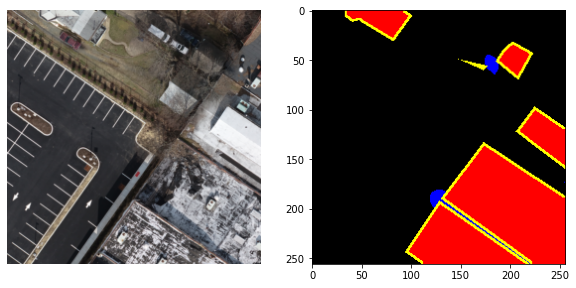

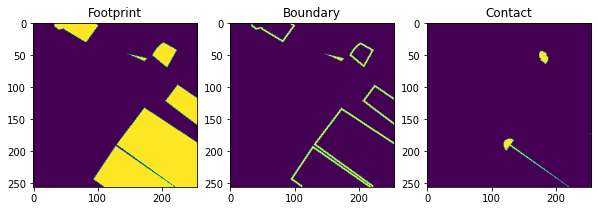

znz001val_19_153759_197299.png


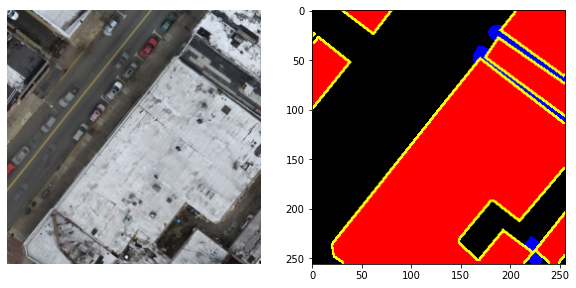

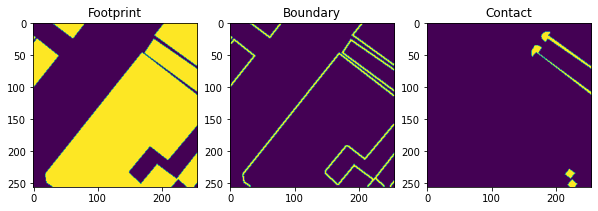

In [45]:
for idx in range(1,3):
    print(data.valid_ds.items[idx].name)
    fig, (ax1,ax2) = plt.subplots(1,2, figsize=(10,5))
    data.valid_ds.x[idx].show(ax=ax1)
    ax2.imshow(image2np(data.valid_ds.y[idx].data*255))
    plt.show()
    show_3ch(data.valid_ds.y[idx])

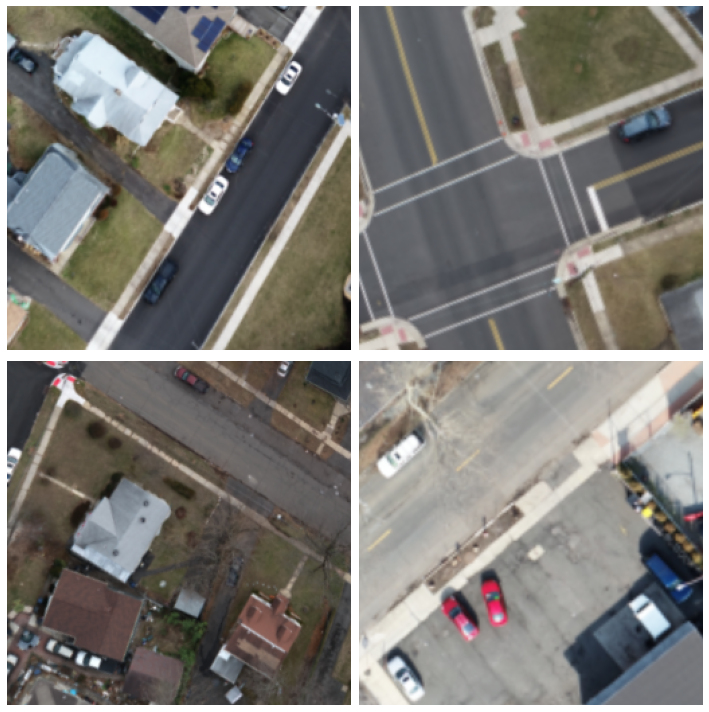

In [46]:
data.show_batch(4,figsize=(10,10), alpha=0.)

In [47]:
data

ImageDataBunch;

Train: LabelList (398 items)
x: SegItemListCustom
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: SegLabelListCustom
ImageSegment (3, 256, 256),ImageSegment (3, 256, 256),ImageSegment (3, 256, 256),ImageSegment (3, 256, 256),ImageSegment (3, 256, 256)
Path: /content/drive/My Drive/Colab Notebooks/fastai/data/images-256;

Valid: LabelList (239 items)
x: SegItemListCustom
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: SegLabelListCustom
ImageSegment (3, 256, 256),ImageSegment (3, 256, 256),ImageSegment (3, 256, 256),ImageSegment (3, 256, 256),ImageSegment (3, 256, 256)
Path: /content/drive/My Drive/Colab Notebooks/fastai/data/images-256;

Test: None

In [0]:
import pdb

def dice_loss(input, target):
#     pdb.set_trace()
    smooth = 1.
    input = torch.sigmoid(input)
    iflat = input.contiguous().view(-1).float()
    tflat = target.contiguous().view(-1).float()
    intersection = (iflat * tflat).sum()
    return 1 - ((2. * intersection + smooth) / ((iflat + tflat).sum() +smooth))

# adapted from https://www.kaggle.com/c/tgs-salt-identification-challenge/discussion/65938
class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2, reduction='mean'):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        BCE_loss = F.binary_cross_entropy_with_logits(inputs, targets.float(), reduction='none')
        pt = torch.exp(-BCE_loss)
        F_loss = self.alpha * (1-pt)**self.gamma * BCE_loss

        if self.reduction == 'mean': return F_loss.mean()
        elif self.reduction == 'sum': return F_loss.sum()
        else: return F_loss

class DiceLoss(nn.Module):
    def __init__(self, reduction='mean'):
        super().__init__()
        self.reduction = reduction
        
    def forward(self, input, target):
        loss = dice_loss(input, target)
        if self.reduction == 'mean': return loss.mean()
        elif self.reduction == 'sum': return loss.sum()
        else: return loss

class MultiChComboLoss(nn.Module):
    def __init__(self, reduction='mean', loss_funcs=[FocalLoss(),DiceLoss()], loss_wts = [1,1], ch_wts=[1,1,1]):
        super().__init__()
        self.reduction = reduction
        self.ch_wts = ch_wts
        self.loss_wts = loss_wts
        self.loss_funcs = loss_funcs 
        
    def forward(self, output, target):
#         pdb.set_trace()
        for loss_func in self.loss_funcs: loss_func.reduction = self.reduction # need to change reduction on fwd pass for loss calc in learn.get_preds(with_loss=True)
        loss = 0
        channels = output.shape[1]
        assert len(self.ch_wts) == channels
        assert len(self.loss_wts) == len(self.loss_funcs)
        for ch_wt,c in zip(self.ch_wts,range(channels)):
            ch_loss=0
            for loss_wt, loss_func in zip(self.loss_wts,self.loss_funcs): 
                ch_loss+=loss_wt*loss_func(output[:,c,None], target[:,c,None])
            loss+=ch_wt*(ch_loss)
        return loss/sum(self.ch_wts)

In [0]:
def acc_thresh_multich(input:Tensor, target:Tensor, thresh:float=0.5, sigmoid:bool=True, one_ch:int=None)->Rank0Tensor:
    "Compute accuracy when `y_pred` and `y_true` are the same size."
    
#     pdb.set_trace()
    if sigmoid: input = input.sigmoid()
    n = input.shape[0]
    
    if one_ch is not None:
        input = input[:,one_ch,None]
        target = target[:,one_ch,None]
    
    input = input.view(n,-1)
    target = target.view(n,-1)
    return ((input>thresh)==target.byte()).float().mean()

def dice_multich(input:Tensor, targs:Tensor, iou:bool=False, one_ch:int=None)->Rank0Tensor:
    "Dice coefficient metric for binary target. If iou=True, returns iou metric, classic for segmentation problems."
#     pdb.set_trace()
    n = targs.shape[0]
    input = input.sigmoid()
    
    if one_ch is not None:
        input = input[:,one_ch,None]
        targs = targs[:,one_ch,None]
    
    input = (input>0.5).view(n,-1).float()
    targs = targs.view(n,-1).float()

    intersect = (input * targs).sum().float()
    union = (input+targs).sum().float()
    if not iou: return (2. * intersect / union if union > 0 else union.new([1.]).squeeze())
    else: return intersect / (union-intersect+1.0)

In [0]:
acc_ch0 = partial(acc_thresh_multich, one_ch=0)
dice_ch0 = partial(dice_multich, one_ch=0)
metrics = [acc_thresh_multich, dice_multich, acc_ch0, dice_ch0]

In [0]:
learn = unet_learner(data, models.resnet50, model_dir='../../models',
                     metrics=metrics, 
                     loss_func=MultiChComboLoss(
                        reduction='mean',
                        loss_funcs=[FocalLoss(gamma=2, alpha=0.5),
                                    DiceLoss(),
                                   ], 
                        loss_wts=[1,1],
                        ch_wts=[1,1,1])
                    )

In [53]:
learn.metrics

[<function __main__.acc_thresh_multich>,
 <function __main__.dice_multich>,
 functools.partial(<function acc_thresh_multich at 0x7f5fd2d84378>, one_ch=0),
 functools.partial(<function dice_multich at 0x7f5fd250a0d0>, one_ch=0)]

In [54]:
learn.loss_func

MultiChComboLoss()

In [55]:
learn.summary()


DynamicUnet
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [64, 128, 128]       9,408      False     
______________________________________________________________________
BatchNorm2d          [64, 128, 128]       128        True      
______________________________________________________________________
ReLU                 [64, 128, 128]       0          False     
______________________________________________________________________
MaxPool2d            [64, 64, 64]         0          False     
______________________________________________________________________
Conv2d               [64, 64, 64]         4,096      False     
______________________________________________________________________
BatchNorm2d          [64, 64, 64]         128        True      
______________________________________________________________________
Conv2d               [64, 64, 64]         36,864     False     
__________________________________________________

In [56]:
learn.lr_find()

epoch,train_loss,valid_loss,acc_thresh_multich,dice_multich,acc_thresh_multich,dice_multich,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 1.45E-07
Min loss divided by 10: 1.00E-04


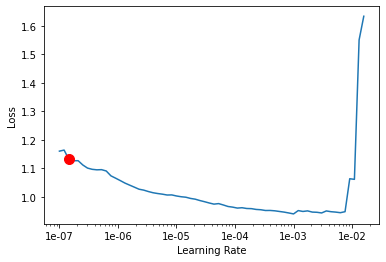

In [57]:
learn.recorder.plot(0,2,suggestion=True)


In [58]:
lr = 1E-03
learn.fit_one_cycle(30, max_lr=lr, 
                    callbacks=[
                        SaveModelCallback(learn,
                                         monitor='dice_multich',
                                         mode='max',
                                         name='znz001trn-focaldice-stage1-best')
                    ]
                   )

epoch,train_loss,valid_loss,acc_thresh_multich,dice_multich,acc_thresh_multich,dice_multich,time
0,0.790073,0.881902,0.919247,0.473413,0.850745,0.563668,03:12
1,0.674426,0.720393,0.951570,0.734432,0.915750,0.815024,01:26
2,0.638791,0.609335,0.947921,0.743419,0.915287,0.827124,01:27
3,0.599734,0.591590,0.952238,0.753577,0.927452,0.843749,01:26
4,0.600686,0.596679,0.956887,0.779004,0.928535,0.851956,01:30
5,0.576255,0.584294,0.958901,0.776655,0.933871,0.854563,01:27
6,0.573529,0.568306,0.954791,0.771632,0.930835,0.854378,01:27
7,0.570505,0.640674,0.958375,0.751758,0.925351,0.820954,01:27
8,0.536086,0.614606,0.957148,0.779084,0.924902,0.845323,01:26
9,0.531000,0.544977,0.961249,0.793661,0.938508,0.865489,01:26


Better model found at epoch 0 with dice_multich value: 0.5636677145957947.
Better model found at epoch 1 with dice_multich value: 0.8150239586830139.
Better model found at epoch 2 with dice_multich value: 0.8271239995956421.
Better model found at epoch 3 with dice_multich value: 0.8437490463256836.
Better model found at epoch 4 with dice_multich value: 0.8519559502601624.
Better model found at epoch 5 with dice_multich value: 0.8545634150505066.
Better model found at epoch 9 with dice_multich value: 0.8654887676239014.
Better model found at epoch 10 with dice_multich value: 0.8741543292999268.
Better model found at epoch 15 with dice_multich value: 0.8778941035270691.
Better model found at epoch 17 with dice_multich value: 0.8864595293998718.
Better model found at epoch 22 with dice_multich value: 0.8871534466743469.
Better model found at epoch 23 with dice_multich value: 0.8876968026161194.
Better model found at epoch 24 with dice_multich value: 0.8913416266441345.
Better model found 

In [59]:
learn.model.eval()
outputs,labels,losses = learn.get_preds(ds_type=DatasetType.Valid,n_batch=3,with_loss=True)
losses.shape

torch.Size([12, 1, 256, 256])

In [60]:
losses_reshaped = torch.mean(losses.view(outputs.shape[0],-1), dim=1)
sorted_idx = torch.argsort(losses_reshaped,descending=True)
losses_reshaped.shape

torch.Size([12])

In [61]:
for i in sorted_idx[:10]:

    print(f'{data.valid_ds.items[i].name}')
    print(f'loss: {losses_reshaped[i].mean()}')
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,5))
    
    data.valid_ds.x[i].show(ax=ax1)
    ax1.set_title('Prediction')
    ax1.imshow(image2np(outputs[i].sigmoid()), alpha=0.4)
    
    ax2.set_title('Ground Truth')
    data.valid_ds.x[i].show(ax=ax2)
    ax2.imshow(image2np(labels[i])*255, alpha=0.4)
    plt.show()
    
    print('Predicted:')
    show_3ch(outputs[i].sigmoid())
    print('Actual:')
    show_3ch(labels[i])

Output hidden; open in https://colab.research.google.com to view.

In [0]:
learn.load('znz001trn-focaldice-stage1-best')
learn.model.train()
learn.unfreeze()

In [63]:
learn.lr_find()

epoch,train_loss,valid_loss,acc_thresh_multich,dice_multich,acc_thresh_multich,dice_multich,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 3.31E-06
Min loss divided by 10: 8.32E-07


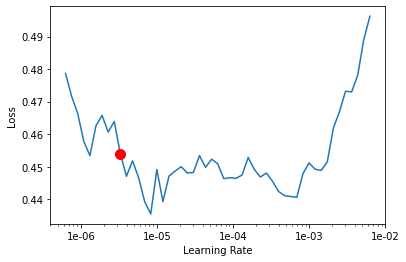

In [64]:
learn.recorder.plot(suggestion=True)

In [65]:
learn.fit_one_cycle(20, max_lr=1e-05, 
                    callbacks=[
                        SaveModelCallback(learn,
                                           monitor='dice_multich',
                                           mode='max',
                                           name='znz001trn-focaldice-unfrozen-best')
                    ]
                   )

epoch,train_loss,valid_loss,acc_thresh_multich,dice_multich,acc_thresh_multich,dice_multich,time
0,0.424566,0.500992,0.970366,0.834827,0.952015,0.893894,01:28
1,0.422038,0.500178,0.970287,0.833788,0.951808,0.892950,01:29
2,0.428380,0.501853,0.970404,0.836368,0.952091,0.894963,01:28
3,0.418598,0.502351,0.970227,0.836412,0.951710,0.894909,01:29
4,0.419122,0.500999,0.970564,0.837130,0.952574,0.895846,01:28
5,0.432120,0.497406,0.970528,0.837012,0.952597,0.895873,01:29
6,0.420679,0.500838,0.970111,0.835067,0.951504,0.893789,01:29
7,0.410898,0.496830,0.970625,0.837343,0.952800,0.896103,01:28
8,0.416665,0.505819,0.969967,0.835570,0.950731,0.893512,01:29
9,0.423767,0.499241,0.970504,0.837127,0.952039,0.895204,01:28


Better model found at epoch 0 with dice_multich value: 0.8938939571380615.
Better model found at epoch 2 with dice_multich value: 0.8949626088142395.
Better model found at epoch 4 with dice_multich value: 0.8958455920219421.
Better model found at epoch 5 with dice_multich value: 0.8958725929260254.
Better model found at epoch 7 with dice_multich value: 0.8961028456687927.
Better model found at epoch 10 with dice_multich value: 0.8963727355003357.


In [66]:
learn.model.eval()
outputs,labels,losses = learn.get_preds(ds_type=DatasetType.Valid,n_batch=6,with_loss=True)
losses_reshaped = torch.mean(losses.view(outputs.shape[0],-1), dim=1)
sorted_idx = torch.argsort(losses_reshaped,descending=True)

In [67]:
for i in sorted_idx[:10]:

    print(f'{data.valid_ds.items[i].name}')
    print(f'loss: {losses_reshaped[i].mean()}')
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,5))
    
    data.valid_ds.x[i].show(ax=ax1)
    ax1.set_title('Prediction')
    ax1.imshow(image2np(outputs[i].sigmoid()), alpha=0.4)
    
    ax2.set_title('Ground Truth')
    data.valid_ds.x[i].show(ax=ax2)
    ax2.imshow(image2np(labels[i])*255, alpha=0.4)
    plt.show()
    
    print('Predicted:')
    show_3ch(outputs[i].sigmoid())
    print('Actual:')
    show_3ch(labels[i])

Output hidden; open in https://colab.research.google.com to view.

In [0]:
learn.export(abs_path+'/models/znz001trn-focaldice.pkl')